In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['SCORES_STD'] = df['SCORES_STD'].fillna(df['SCORES_STD'].mean())
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
     # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category) 
    del test_df
    gc.collect()
    return df
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean'] 
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')  
    for e in cols:
        bureau_agg['RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]   
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }        
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    for e in cols:
        prev_agg['RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()] 
    gc.collect()
    return prev_agg
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']   
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg 
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/Users/cobydavis/Desktop/ML Project/data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg
def process_data(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    print("Overall df shape:", df.shape)
    return df

In [66]:
import xgboost as xgb
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=3,early_stopping_rounds=10):
    print("Starting XGBoost. Train shape: {}".format(dtrain.shape))
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        print("Step 1")
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        print("Step 2")
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    print("Fitting Algorithm")
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'],eval_metric='auc')
        
    #Predict training set:
    print("Predicting")
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print(dtrain_predictions)
    print(dtrain_predprob)
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    plt.figure(0)
    feat_imp[0:50].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    # ROC curve
    fpr, tpr, threshold = metrics.roc_curve(dtrain['TARGET'], dtrain_predprob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    del dtrain, xgtrain
    gc.collect()
    return (alg,feat_imp,cvresult)


In [ ]:
dfsmall=process_data(debug= True)
df=process_data(debug= False)

(10000, 834)
Making Predictors
(10000, 834)
831
Starting XGBoost. Train shape: (10000, 834)
Step 1
Step 2
[0]	train-auc:0.729654+0.0158821	test-auc:0.692114+0.013283
[1]	train-auc:0.759618+0.010823	test-auc:0.708298+0.0117931
[2]	train-auc:0.779247+0.0104149	test-auc:0.713393+0.00939871
[3]	train-auc:0.789809+0.0102003	test-auc:0.715392+0.00882996
[4]	train-auc:0.80154+0.0130481	test-auc:0.71441+0.0106344
[5]	train-auc:0.809355+0.0129659	test-auc:0.713169+0.0128167
[6]	train-auc:0.812791+0.0138804	test-auc:0.716062+0.0141458
[7]	train-auc:0.81867+0.0100276	test-auc:0.72121+0.00914826
[8]	train-auc:0.824468+0.00948053	test-auc:0.720799+0.00932997
[9]	train-auc:0.829536+0.00763031	test-auc:0.722236+0.0108366
[10]	train-auc:0.83622+0.00841537	test-auc:0.722793+0.0105373
[11]	train-auc:0.841927+0.0110633	test-auc:0.722459+0.0102851
[12]	train-auc:0.844139+0.00973342	test-auc:0.724074+0.0091185
[13]	train-auc:0.847791+0.0103518	test-auc:0.726725+0.00828821
[14]	train-auc:0.850833+0.011957	t

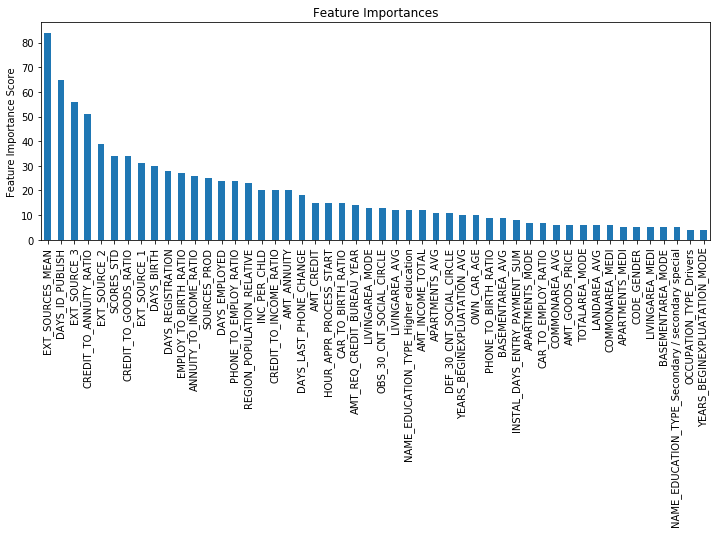

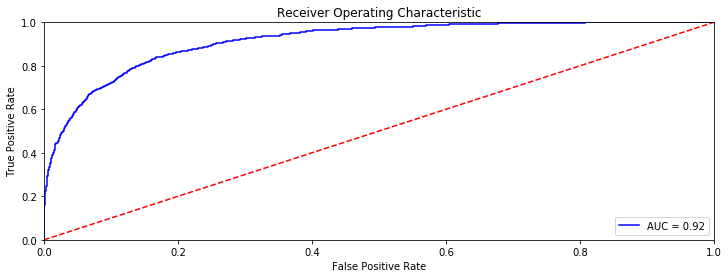

Best Iteration: 44


0

In [67]:
#Choose all predictors except target & IDcols
target = 'TARGET'
trainsmall = dfsmall[dfsmall['TARGET'].notnull()]
print(trainsmall.shape)
print("Making Predictors")
#remove all ID variavles that could affect learning parameters
predictors = [f for f in trainsmall.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
print(trainsmall.shape)
print(len(predictors))
xgbtest = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
(alg,feat_imp,cvresult)=modelfit(xgbtest, trainsmall, predictors)
best_iteration=len(cvresult)
print("Best Iteration: " +str(best_iteration))
gc.collect()

Making Predictors
(307511, 864)
50
Starting XGBoost. Train shape: (307511, 864)
Step 1
Step 2
[0]	train-auc:0.724452+0.0017299	test-auc:0.719988+0.00211662
[1]	train-auc:0.731319+0.000643053	test-auc:0.726423+0.00313891
[2]	train-auc:0.73363+0.00260091	test-auc:0.728151+0.00134546
[3]	train-auc:0.736585+0.00205331	test-auc:0.730604+0.00182899
[4]	train-auc:0.737759+0.00157865	test-auc:0.731279+0.0025194
[5]	train-auc:0.739571+0.00179797	test-auc:0.732971+0.00171965
[6]	train-auc:0.740015+0.00189077	test-auc:0.733278+0.00161713
[7]	train-auc:0.740976+0.00158975	test-auc:0.734159+0.00162084
[8]	train-auc:0.741513+0.00137842	test-auc:0.7345+0.00156853
[9]	train-auc:0.742137+0.00130307	test-auc:0.734908+0.00161082
[10]	train-auc:0.742419+0.00150779	test-auc:0.735058+0.00143553
[11]	train-auc:0.743146+0.00107976	test-auc:0.735617+0.0019883
[12]	train-auc:0.743702+0.00118103	test-auc:0.735995+0.00187717
[13]	train-auc:0.744205+0.00117797	test-auc:0.736353+0.0018728
[14]	train-auc:0.744782+0.

[127]	train-auc:0.802116+0.00154704	test-auc:0.763334+0.00237333
[128]	train-auc:0.802385+0.00162542	test-auc:0.763385+0.00225926
[129]	train-auc:0.802683+0.00154019	test-auc:0.7634+0.00222936
[130]	train-auc:0.802963+0.00154478	test-auc:0.76342+0.00220811
[131]	train-auc:0.803197+0.00162672	test-auc:0.763404+0.0022386
[132]	train-auc:0.803531+0.0016514	test-auc:0.763422+0.00227688
[133]	train-auc:0.803742+0.00172578	test-auc:0.763406+0.00227688
[134]	train-auc:0.804011+0.00160593	test-auc:0.763506+0.00233824
[135]	train-auc:0.804203+0.00158895	test-auc:0.763531+0.00228491
[136]	train-auc:0.804455+0.00164865	test-auc:0.763513+0.00228197
[137]	train-auc:0.804706+0.001589	test-auc:0.763524+0.00228319
[138]	train-auc:0.804885+0.00160232	test-auc:0.763574+0.0022395
[139]	train-auc:0.805167+0.00158075	test-auc:0.763583+0.00223484
[140]	train-auc:0.80547+0.0016111	test-auc:0.763591+0.00223684
[141]	train-auc:0.805691+0.00153901	test-auc:0.763603+0.00222932
[142]	train-auc:0.805922+0.00148643

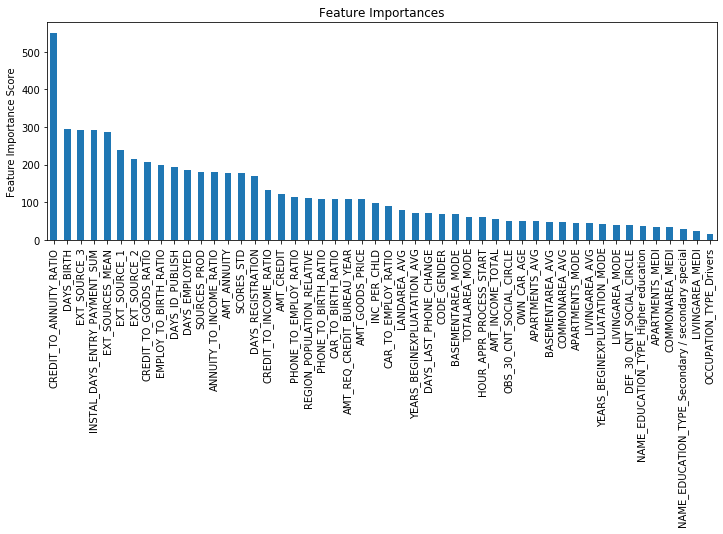

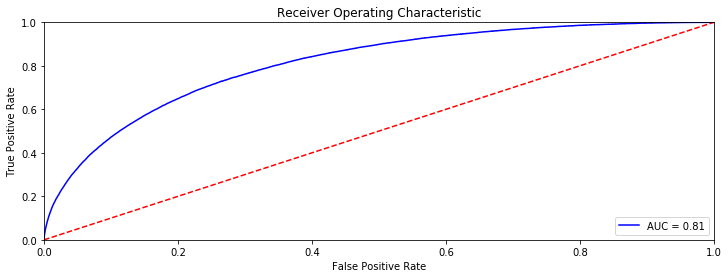

Best Iteration: 220


0

In [68]:
#Choose all predictors except target & IDcols
target = 'TARGET'
train = df[df['TARGET'].notnull()]
print("Making Predictors")
predictors=feat_imp.axes[0][0:50]
print(train.shape)
print(len(predictors))
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
(alg,feat_imp,cvresult)=modelfit(xgb1, train, predictors)
best_iteration=len(cvresult)
print("Best Iteration: " +str(best_iteration))
gc.collect()

In [35]:
param_test1 = {
 'max_depth':range(2,6,2),
 'min_child_weight':range(2,6,2)
}
print(train.shape)
print(len(predictors))
print("Starting Gridsearch")
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=best_iteraion, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=10)
print("Fitting Parameter Test 4")
gsearch1.fit(train[predictors],train[target])
print(gsearch1.best_params_)
best_max_depth=gsearch1.best_params_["max_depth"]
best_min_child_weight=gsearch1.best_params_["min_child_weight"]

(307511, 864)
50
Starting Gridsearch
Fitting Parameter Test 4
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:  8.5min remaining:  2.1min
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 10.8min finished


{'max_depth': 4, 'min_child_weight': 2}


In [36]:
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

{'mean_fit_time': array([ 93.26483731,  92.15124474, 161.88030205, 154.67708411]), 'std_fit_time': array([ 2.59141551,  4.44815988,  1.63082354, 14.49008041]), 'mean_score_time': array([0.44945889, 0.3999877 , 0.6070962 , 0.44050527]), 'std_score_time': array([0.08300261, 0.03291897, 0.07057049, 0.12603336]), 'param_max_depth': masked_array(data=[2, 2, 4, 4],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[2, 4, 2, 4],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2, 'min_child_weight': 2}, {'max_depth': 2, 'min_child_weight': 4}, {'max_depth': 4, 'min_child_weight': 2}, {'max_depth': 4, 'min_child_weight': 4}], 'split0_test_score': array([0.74856395, 0.74856395, 0.75886806, 0.75899426]), 'split1_test_score': array([0.75103845, 0.75103469, 0.7608595 , 0.75990003]), 'split2_test_score': array([0.74531497, 0.74529395, 

In [38]:
param_test2 = {
 'max_depth':[best_max_depth-1,best_max_depth,best_max_depth+1],
 'min_child_weight':[best_min_child_weight-1,best_min_child_weight,best_min_child_weight+1]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=best_iteration, max_depth=best_max_depth,
 min_child_weight=best_min_child_weight, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5,verbose=10)
print("Fitting Parameter Test 4")
gsearch2.fit(train[predictors],train[target])
print("Best Depth and Weights are:")
print(gsearch2.best_params_)
best_max_depth=gsearch2.best_params_["max_depth"]
best_min_child_weight=gsearch2.best_params_["min_child_weight"]
print(gsearch2.best_params_, gsearch2.best_score_)

Fitting Parameter Test 4
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed: 13.2min remaining:   36.8s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 13.8min finished


Best Depth and Weights are:
{'max_depth': 5, 'min_child_weight': 3}


In [43]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=best_iteration, max_depth=best_max_depth,
 min_child_weight=best_min_child_weight, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5,verbose=10)
print("Fitting Parameter Test 4")
gsearch3.fit(train[predictors],train[target])
print("Best Gamma is:")
print(gsearch3.best_params_)
best_gamma=gsearch3.best_params_["gamma"]
print(gsearch3.best_params_, gsearch3.best_score_)

Fitting Parameter Test 4
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:  9.1min remaining:  1.7min
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  9.8min finished


Best Gamma is:
{'gamma': 0.1}
{'gamma': 0.1} 0.7510305468779176


In [44]:
print(train.shape)
print(predictors.shape)

(307511, 864)
(50,)


Starting XGBoost. Train shape: (307511, 864)
Step 1
Step 2
[0]	train-auc:0.724757+0.00181742	test-auc:0.720107+0.00225548
[1]	train-auc:0.731711+0.000634632	test-auc:0.72662+0.00335493
[2]	train-auc:0.733855+0.00258952	test-auc:0.728348+0.00136373
[3]	train-auc:0.736821+0.00207978	test-auc:0.73079+0.00185613
[4]	train-auc:0.73795+0.00161819	test-auc:0.731438+0.00261387
[5]	train-auc:0.739565+0.00186255	test-auc:0.732841+0.00196058
[6]	train-auc:0.740207+0.00185076	test-auc:0.733356+0.00189839
[7]	train-auc:0.741063+0.00168134	test-auc:0.734358+0.00188953
[8]	train-auc:0.741751+0.00170006	test-auc:0.734733+0.00166144
[9]	train-auc:0.74248+0.00173235	test-auc:0.735219+0.001631
[10]	train-auc:0.742663+0.00179274	test-auc:0.735325+0.0015351
[11]	train-auc:0.743419+0.00128738	test-auc:0.735956+0.00215028
[12]	train-auc:0.744036+0.00134314	test-auc:0.736314+0.00202632
[13]	train-auc:0.744516+0.00127027	test-auc:0.736622+0.00195836
[14]	train-auc:0.745111+0.00112862	test-auc:0.736996+0.002201

[128]	train-auc:0.800021+0.0019295	test-auc:0.763352+0.00196329
[129]	train-auc:0.800321+0.00181063	test-auc:0.763362+0.00195609
[130]	train-auc:0.800631+0.00166505	test-auc:0.763417+0.00198491
[131]	train-auc:0.800833+0.00169762	test-auc:0.763415+0.00200637
[132]	train-auc:0.801229+0.00167381	test-auc:0.763422+0.00205351
[133]	train-auc:0.801562+0.00157282	test-auc:0.763531+0.00212509
[134]	train-auc:0.80176+0.00161851	test-auc:0.763516+0.00213193
[135]	train-auc:0.801946+0.00158262	test-auc:0.7635+0.00209356
[136]	train-auc:0.80227+0.0014951	test-auc:0.763551+0.00214656
[137]	train-auc:0.802466+0.00152978	test-auc:0.76357+0.00215552
[138]	train-auc:0.802686+0.0015607	test-auc:0.763616+0.00210035
[139]	train-auc:0.802865+0.00158085	test-auc:0.763611+0.00213881
[140]	train-auc:0.803097+0.00153898	test-auc:0.763599+0.00212518
[141]	train-auc:0.803345+0.00147787	test-auc:0.763663+0.00215274
[142]	train-auc:0.803517+0.00141421	test-auc:0.763684+0.00219302
[143]	train-auc:0.803846+0.001345

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=3, missing=None, n_estimators=224, n_jobs=1,
               nthread=4, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
               silent=None, subsample=0.8, verbosity=1),
 CREDIT_TO_ANNUITY_RATIO                              542
 EXT_SOURCES_MEAN                                     306
 DAYS_BIRTH                                           288
 EXT_SOURCE_3                                         268
 INSTAL_DAYS_ENTRY_PAYMENT_SUM                        263
 EXT_SOURCE_1                                         215
 CREDIT_TO_GOODS_RATIO                                194
 DAYS_ID_PUBLISH                                      193
 EXT_SOURCE_2                                         188

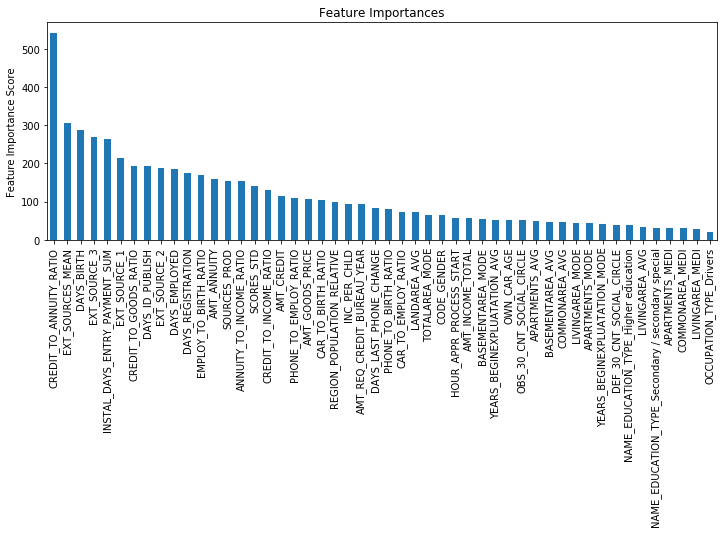

In [45]:
#recalibrate
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=best_max_depth,
 min_child_weight=best_min_child_weight,
 gamma=best_gamma,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [106]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=best_max_depth,
 min_child_weight=best_min_child_weight, gamma=best_gamma, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print("Fitting Parameter Test 4")
gsearch4.fit(train[predictors],train[target])
print(gsearch4.best_params_)
best_subsample=gsearch4.best_params_["subsample"]
best_colsample_bytree=gsearch4.best_params_["colsample_bytree"]

{'colsample_bytree': 0.6, 'subsample': 0.8}


In [111]:
param_test5 = {
 'subsample':[i/100.0 for i in range(round(best_subsample*100)-5,round(best_subsample*100)+10,5)],
 'colsample_bytree':[i/100.0 for i in range(round(best_colsample_bytree*100)-5,round(best_colsample_bytree*100)+10,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=best_max_depth,
 min_child_weight=best_min_child_weight, gamma=best_gamma, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print("Fitting Parameter Test 5")
gsearch5.fit(train[predictors],train[target])
print(gsearch5.best_params_)
best_subsample=gsearch5.best_params_["subsample"]
best_colsample_bytree=gsearch5.best_params_["colsample_bytree"]

Fitting Parameter Test 5
{'colsample_bytree': 0.65, 'subsample': 0.8}


In [123]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=best_max_depth,
 min_child_weight=best_min_child_weight, gamma=best_gamma, subsample=best_subsample, colsample_bytree=best_colsample_bytree,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print("Fitting Parameter Test 6")
gsearch6.fit(train[predictors],train[target])
print(gsearch6.best_params_)
best_reg_alpha=gsearch6.best_params_["reg_alpha"]

Fitting Parameter Test 6
{'mean_fit_time': array([10.99006801, 11.06244597, 11.30867305, 11.40969324, 10.37476201]), 'std_fit_time': array([0.18934887, 0.25848233, 0.07277239, 0.11548402, 2.36605009]), 'mean_score_time': array([0.07806544, 0.07452784, 0.06883731, 0.07634811, 0.05407119]), 'std_score_time': array([0.01162839, 0.00976433, 0.01619905, 0.02200204, 0.01860382]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([0.77585278, 0.77585628, 0.77671824, 0.77758021, 0.75599441]), 'split1_test_score': array([0.72411574, 0.72412274, 0.72451788, 0.72563686, 0.71661334]), 'split2_test_score': array([0.77579509, 0.7757811 , 0.77613428, 0.77524259, 0.74211207]), 'split3_test_score': array([0.7533106 , 0.75330711, 0.75427572, 0.7527

In [127]:
param_test7 = {
 'reg_alpha':[0, 0.1, 0.5, 1, 5]*best_reg_alpha
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=best_max_depth,
 min_child_weight=best_min_child_weight, gamma=best_gamma, subsample=best_subsample, colsample_bytree=best_colsample_bytree,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print("Fitting Parameter Test 7")
gsearch7.fit(train[predictors],train[target])
print(gsearch6.best_params_)
best_reg_alpha=gsearch7.best_params_["reg_alpha"]

Fitting Parameter Test 7
{'mean_fit_time': array([11.15478334, 10.9482358 , 10.52242184, 10.21164351, 10.16888742]), 'std_fit_time': array([0.16497188, 0.21411763, 0.23883692, 0.03744534, 2.18598728]), 'mean_score_time': array([0.06280694, 0.06317849, 0.05789194, 0.05908155, 0.05450869]), 'std_score_time': array([0.00723554, 0.01374063, 0.00491495, 0.00484638, 0.01574   ]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([0.77585278, 0.77585628, 0.77671824, 0.77758021, 0.75599441]), 'split1_test_score': array([0.72411574, 0.72412274, 0.72451788, 0.72563686, 0.71661334]), 'split2_test_score': array([0.77579509, 0.7757811 , 0.77613428, 0.77524259, 0.74211207]), 'split3_test_score': array([0.7533106 , 0.75330711, 0.75427572, 0.7527

Starting XGBoost. Train shape: (10000, 840)
Step 1
Step 2
[0]	train-auc:0.573856+0.0218729	test-auc:0.564314+0.012325
[1]	train-auc:0.655628+0.0181113	test-auc:0.633822+0.0229189
[2]	train-auc:0.691553+0.0031046	test-auc:0.67922+0.0159435
[3]	train-auc:0.691385+0.0026985	test-auc:0.679139+0.0162579
[4]	train-auc:0.6932+0.000700743	test-auc:0.683159+0.016954
[5]	train-auc:0.701062+0.0083857	test-auc:0.684973+0.0124445
[6]	train-auc:0.70193+0.00852954	test-auc:0.685592+0.0122743
[7]	train-auc:0.704265+0.00855261	test-auc:0.688248+0.00726176
[8]	train-auc:0.708021+0.00686051	test-auc:0.693151+0.00846518
[9]	train-auc:0.710874+0.0104844	test-auc:0.697342+0.00277573
[10]	train-auc:0.716314+0.0081737	test-auc:0.704246+0.0107894
[11]	train-auc:0.72198+0.0116415	test-auc:0.704986+0.0110606
[12]	train-auc:0.722366+0.0113872	test-auc:0.705758+0.011733
[13]	train-auc:0.72229+0.0113616	test-auc:0.705715+0.0116053
[14]	train-auc:0.722123+0.0114594	test-auc:0.70495+0.0121352
[15]	train-auc:0.722105+

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=None, n_estimators=26, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

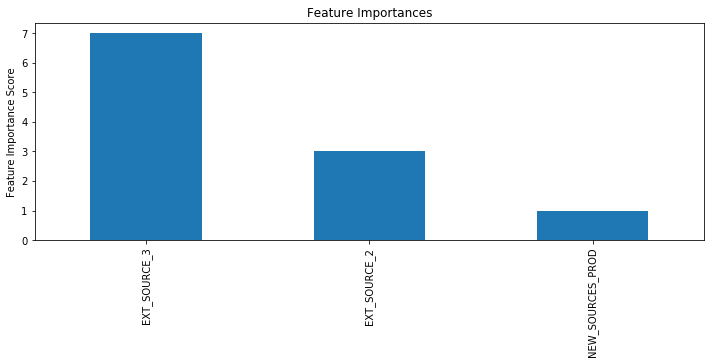

In [128]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=best_max_depth,
 min_child_weight=best_min_child_weight,
 gamma=best_gamma,
 subsample=best_subsample,
 colsample_bytree=best_colsample_bytree,
 reg_alpha=best_reg_alpha,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

Starting XGBoost. Train shape: (307511, 864)
Step 1
Step 2
[0]	train-auc:0.719113+0.00125006	test-auc:0.71654+0.00242925
[1]	train-auc:0.725503+0.000785495	test-auc:0.721989+0.0030459
[2]	train-auc:0.727614+0.00228166	test-auc:0.723803+0.00106717
[3]	train-auc:0.73019+0.00160537	test-auc:0.726316+0.00183304
[4]	train-auc:0.731319+0.00173975	test-auc:0.727493+0.0017546
[5]	train-auc:0.732508+0.00217108	test-auc:0.728488+0.00105785
[6]	train-auc:0.733033+0.00216218	test-auc:0.729081+0.00106767
[7]	train-auc:0.733586+0.00194198	test-auc:0.729703+0.0014152
[8]	train-auc:0.733904+0.00167493	test-auc:0.729995+0.00144126
[9]	train-auc:0.734362+0.00173484	test-auc:0.730286+0.00163234
[10]	train-auc:0.734856+0.00184078	test-auc:0.73073+0.00138145
[11]	train-auc:0.735535+0.00113252	test-auc:0.731447+0.00205007
[12]	train-auc:0.73605+0.00127117	test-auc:0.731971+0.00192573
[13]	train-auc:0.736362+0.00128788	test-auc:0.732275+0.00191102
[14]	train-auc:0.736826+0.00112435	test-auc:0.732672+0.002079

[127]	train-auc:0.780559+0.00103451	test-auc:0.760968+0.00204811
[128]	train-auc:0.780822+0.00101078	test-auc:0.761103+0.00204937
[129]	train-auc:0.781052+0.00102216	test-auc:0.761197+0.00200896
[130]	train-auc:0.781256+0.000985554	test-auc:0.761251+0.00204228
[131]	train-auc:0.781494+0.000906147	test-auc:0.761414+0.00213573
[132]	train-auc:0.781801+0.000856151	test-auc:0.761488+0.00217739
[133]	train-auc:0.781959+0.000879155	test-auc:0.761486+0.00217948
[134]	train-auc:0.782208+0.000820527	test-auc:0.761611+0.00222372
[135]	train-auc:0.782325+0.000830297	test-auc:0.76165+0.0021696
[136]	train-auc:0.782505+0.000819009	test-auc:0.761684+0.00219751
[137]	train-auc:0.782688+0.000809623	test-auc:0.761689+0.00222659
[138]	train-auc:0.782844+0.000798636	test-auc:0.761747+0.00222535
[139]	train-auc:0.782951+0.000815615	test-auc:0.76177+0.0022099
[140]	train-auc:0.783129+0.000821259	test-auc:0.76183+0.00220277
[141]	train-auc:0.783319+0.000776181	test-auc:0.761908+0.00224071
[142]	train-auc:0.

[254]	train-auc:0.799566+0.00132191	test-auc:0.765233+0.00220897
[255]	train-auc:0.799686+0.00130517	test-auc:0.765244+0.00217983
[256]	train-auc:0.799821+0.00131535	test-auc:0.765211+0.00215987
[257]	train-auc:0.799923+0.00126831	test-auc:0.765223+0.0021885
[258]	train-auc:0.800066+0.00122856	test-auc:0.765238+0.00219342
[259]	train-auc:0.800192+0.00121797	test-auc:0.765236+0.00220406
[260]	train-auc:0.800324+0.00124584	test-auc:0.765232+0.002197
[261]	train-auc:0.800471+0.00126215	test-auc:0.765216+0.00220689
[262]	train-auc:0.800554+0.00125543	test-auc:0.76522+0.0021614
[263]	train-auc:0.800693+0.00123881	test-auc:0.765252+0.00214078
[264]	train-auc:0.800835+0.00126454	test-auc:0.76528+0.00211983
[265]	train-auc:0.800993+0.00129534	test-auc:0.765273+0.00213138
[266]	train-auc:0.801156+0.00124305	test-auc:0.765282+0.00215083
[267]	train-auc:0.801307+0.0012453	test-auc:0.765295+0.00214067
[268]	train-auc:0.801428+0.00127191	test-auc:0.765321+0.002131
[269]	train-auc:0.80151+0.00128856

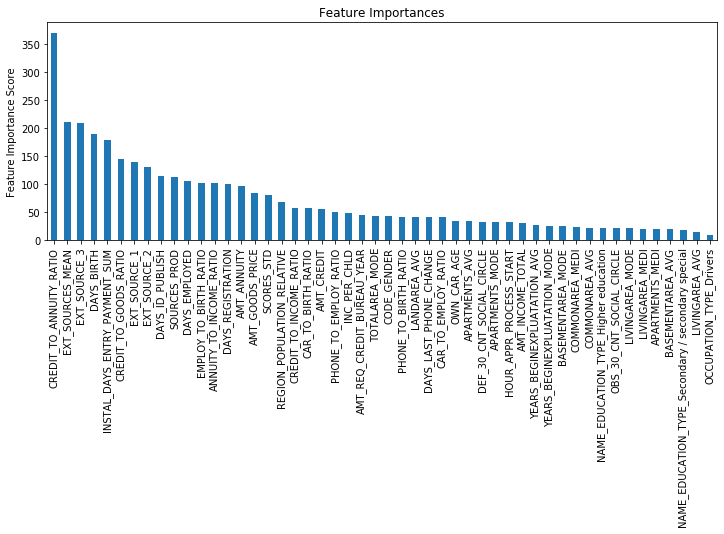

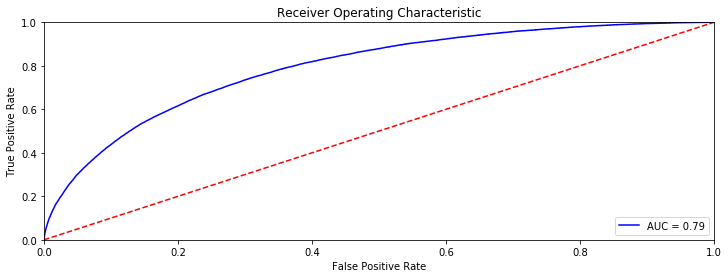

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=4,
               min_child_weight=6, missing=None, n_estimators=274, n_jobs=1,
               nthread=4, objective='binary:logistic', random_state=0,
               reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
               silent=None, subsample=0.8, verbosity=1),
 CREDIT_TO_ANNUITY_RATIO                              371
 EXT_SOURCES_MEAN                                     211
 EXT_SOURCE_3                                         210
 DAYS_BIRTH                                           189
 INSTAL_DAYS_ENTRY_PAYMENT_SUM                        179
 CREDIT_TO_GOODS_RATIO                                144
 EXT_SOURCE_1                                         139
 EXT_SOURCE_2                                         131
 DAYS_ID_PUBLISH                                      1

In [70]:
# xgb4 = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=5000,
#  max_depth=best_max_depth,
#  min_child_weight=best_min_child_weight,
#  gamma=best_gamma,
#  subsample=best_subsample,
#  colsample_bytree=best_colsample_bytree,
#  reg_alpha=best_reg_alpha,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# modelfit(xgb4, train, predictors)
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [48]:
# define a binning function
# bin values according to their reported value in each feature
max_bin = 20
force_bin = 5
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    # compute distribution of flagged traders and distribution of non default traders for each grouping
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

# compute all the required information for getting information values
def char_bin(Y, X):   
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)
    
# display all the information in an array
def data_vars(df1, target):
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)

    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

##########################   
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
from scipy.spatial.distance import euclidean
import matplotlib
import matplotlib.pyplot as plt
import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, recall_score,auc
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
# import scikitplot as skplt

(307511, 864)
(307511, 50)


/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done Sorting


/Users/cobydavis/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting Logistic
Optimization terminated successfully.
         Current function value: 0.604849
         Iterations 5
                                           Results: Logit
Model:                          Logit                       Pseudo R-squared:            -1.156     
Dependent Variable:             TARGET                      AIC:                         372035.3516
Date:                           2019-12-20 17:36            BIC:                         372248.0769
No. Observations:               307511                      Log-Likelihood:              -1.8600e+05
Df Model:                       19                          LL-Null:                     -86271.    
Df Residuals:                   307491                      LLR p-value:                 1.0000     
Converged:                      1.0000                      Scale:                       1.0000     
No. Iterations:                 5.0000                                                              
---------------

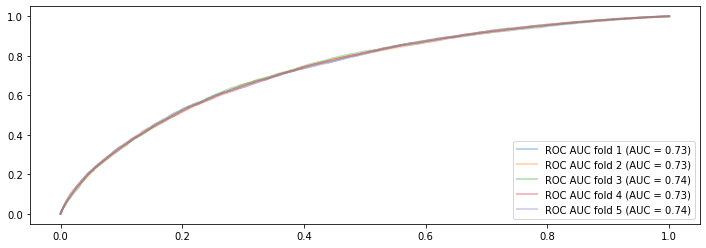

Accuracy of logistic regression classifier on test set: 0.87
[[77870  7044]
 [ 5111  2229]]
Recall Score 0.30367847411444143


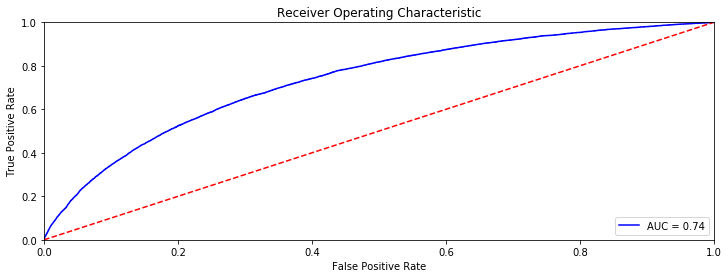

In [49]:
features = df[df['TARGET'].notnull()]
features=features.fillna(0)
features = features.replace([np.inf, -np.inf], 0)
print(features.shape)
predictors = [f for f in features.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
target = features.TARGET
predictors=feat_imp.axes[0][0:50]
features=features[predictors]
print(features.shape)
final_iv, IV = data_vars(features,target)
"""# Apply WOE values to your dataframe columns"""
sortedFeatures = IV.sort_values(by = 'IV', ascending = False)
print("Done Sorting")
### select top 20 features in terms of IV
impFeatures = features[list(sortedFeatures.iloc[:20].VAR_NAME)]
transform_vars_list = impFeatures.columns.difference(['target'])
transform_prefix = 'new_' 
transform_vars_list
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            impFeatures[transform_prefix + var] = impFeatures[var].apply(lambda x: eval(replace_cmd))
        except:
            impFeatures[transform_prefix + var] = impFeatures[var].apply(lambda x: eval(replace_cmd1))

# create 'new' variables that are WOE variables, that are copied to features array
explan_vars_in_woe = impFeatures.iloc[:,-int(impFeatures.shape[1]/2):]

"""Regression Modelling"""
# we can use SMOTE oversampling algorithm to generate more scenarios where traders are labelled as 'flagged'
# since when the model is run without it, it predicts 0 flagged traders

logit_model=sm.Logit(target,explan_vars_in_woe);
print("Fitting Logistic")
result=logit_model.fit();
print(result.summary2());
#check the pvalue and if less than 0.05, reject the null hypothesis
#logistic regression model fitting with those seleted variables


#K Fold Cross Validation
print('Training Data Shape: ', explan_vars_in_woe.shape)

# Extract feature names
feature_names = list(explan_vars_in_woe.columns)

# Convert to np arrays
training_matrix = np.array(explan_vars_in_woe)

# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

model = LogisticRegression()
# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []

#fold counter
i=1

for train,test in k_fold.split(explan_vars_in_woe,target):
    prob = model.fit(explan_vars_in_woe.iloc[train],target.iloc[train]).predict_proba(explan_vars_in_woe.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(target.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

X_train, X_test, Y_train, Y_test = np.asarray(train_test_split(explan_vars_in_woe, target, test_size=0.3, random_state=0))

# use SMOTE for oversampling minority class
smt = SMOTE(random_state = 0,sampling_strategy = 0.4)
X_train, Y_train = smt.fit_sample(X_train, Y_train)

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
probs = logreg.predict_proba(X_test)

THRESHOLD = 0.5
Y_pred = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

#Y_pred = logreg.predict(explan_vars_in_woe)
#Predicting the test set results and calculating the accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))
#confusion matrix
confusionMatrix = confusion_matrix(Y_test, Y_pred)
print(confusionMatrix)
print('Recall Score',recall_score(Y_test, Y_pred))


"""Diagnostics"""

# # gain and lift chart
# skplt.metrics.plot_cumulative_gain(Y_test, probs)
# plt.show()

# ROC curve
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)

roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()